# Analysis of Data Science Jobs HR Agency Data

## Task description

Anylyse data and draw conclusions based on the received results. Ammend your reasoning with visualization. Using statistical analysis prove whether the conclusions are statistically significant.

In the course of your analysis you must:
1. Identify, which factors influence upon the salary of a "Data Scientist".
2. Answer the key questions of the HR agency:
* Is there a yearly salary growth for the "Data Scientist" jobs?
* What is the relation between the salaries of the "Data Scientist" and "Data Engineer" jobs in 2022?
* What is the relation between the "Data Scientist" salary and the company size?
* Is there an interrelation between the company size and the presence of the "Data Scientist" or "Data Engineer" jobs in it?
If you find other interesting patterns in the data, also mention them in your analysis.

Demonstrate usage of different statistical tests to check the statistical significance of your conclusions.
* Tests for a numeric feature:
    * One-sample group tests
    * Two-sample groups tests
    * Multiple sample groups tests
* Tests for a categorical feature.

## Dataset

For the analysis we use use the [Data Science Job Salaries](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries) dataset from Kaggle.

Data contains the following columns:
* work_year: year in which the salary has been paid
* experience_level: experience level on this role. The following values are possible:
    * EN — Entry-level/Junior
    * MI — Mid-level/Intermediate
    * SE — Senior-level/Expert
    * EX — Executive-level/Director
* employment_type: employment type for this role. The following values are possible:
    * PT — part time
    * FT — full time
    * CT — contract
    * FL — freelancer
* job_title: title of the role
* salary: brutto salary
* salary_currency: currency in which the salary has been paid (ISO 4217)
* salary_in_usd: salary value converted to USD using the yearly average exchange rate from fxdata.foorilla.com
* employee_residence: main residence country of the employee during the given year (ISO 3166)
* remote_ratio: ration of work which has been done remotely. The following values are possible:
    * 0 — no remote work (< 20 %)
    * 50 — partially remote work (>= 20 % and <= 80 %)
    * 100 — mainly remote work (> 80 %)
* company_location: country of the main employer office (ISO 3166)
* company_size:	average amount of people who worked in the company during the given year. The following values are possible:
    * S — < 50 employees (small company)
    * M — >= 50 and <= 250 employees (middle-size company)
    * L — > 250 employees (large company)

## Import of libraries

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
import sys

sys.path.append('../../')

from DataScienceHelpers.DataCleaningAttributes import find_low_information_attributes
from DataScienceHelpers.ExploratoryDataAnalysis import display_pvalue_conclusion
from DataScienceHelpers.ExploratoryDataAnalysis import display_shapiro


## Loading data

In [57]:
data = pd.read_csv('../../data/ds_salaries.csv')
display(f'Number of records: {data.shape[0]}')
data.head()

'Number of records: 607'

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


## Data cleaning

### Empty cells
Identify empty cells and if necessary delete columns / rows which contain them.

In [58]:
data.isnull().sum()

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

The dataset does not contain empty cells.

### Low information features

Check if the dataset contains any low information features and delete those. For that I use the DataScienceHelpers library which I have developed in the course of the previous modules.

In [33]:
low_inf_attrs = find_low_information_attributes(data)
low_inf_attrs


[('Unnamed: 0', 1.0, 'nunique_ratio'),
 ('employment_type', 0.9686985172981878, 'top_freq')]

The 'Unnamed: 0' is an external index column, which contains 100 % unique values. This column can be safely dropped, because pandas generates a new index for us while reading data.

The 'employment_type' column contains a value, which is present in around 97 % of the rows. Let's check the frequency of the values of the 'employment_type' column.

In [34]:
data['employment_type'].value_counts()

employment_type
FT    588
PT     10
CT      5
FL      4
Name: count, dtype: int64

The value 'FT' (full time job) is the most frequent one.

Since this feature is not mentioned in the task description, I will drop it in addition to 'Unnamed: 0'.

In [35]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop('employment_type', axis=1, inplace=True)

### Duplicates

Check if the dataset contains any duplicates and delete those.

In [36]:
dupl_mask = data.duplicated()
dupl_data = data[dupl_mask]

number_with_duplicates = data.shape[0]
number_of_duplicates = dupl_data.shape[0]

data = data.drop_duplicates()
number_without_duplicates = data.shape[0]

display(f'Number or records with duplicates: {number_with_duplicates}')
display(f'Number of duplicates: {number_of_duplicates}')
display(f'Number or records without duplicates: {number_without_duplicates}')

'Number or records with duplicates: 607'

'Number of duplicates: 42'

'Number or records without duplicates: 565'

### Data type check

For each column check if the column data is matching the data type used within the dataframe.

In [37]:
display(data.head())
data.info()

,work_year,experience_level,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,Machine Learning Engineer,150000,USD,150000,US,50,US,L


<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   job_title           565 non-null    object
 3   salary              565 non-null    int64 
 4   salary_currency     565 non-null    object
 5   salary_in_usd       565 non-null    int64 
 6   employee_residence  565 non-null    object
 7   remote_ratio        565 non-null    int64 
 8   company_location    565 non-null    object
 9   company_size        565 non-null    object
dtypes: int64(4), object(6)
memory usage: 48.6+ KB


Column meaningful data types are matching the data types used in the dataframe.

### Classify feature by type (numeric or categorical)

* work_year - numeric
* experience_level - categorical
* job_title - categorical
* salary - numeric
* salary_currency - categorical
* salary_in_usd - numeric
* employee_residence - categorical
* remote_ratio - categorical
* company_location - categorical
* company_size - categorical

### Main statistical characteristics of the features

In [38]:
display('Statistic characteristics of the features:')
data.describe(include='all')

'Statistic characteristics of the features:'

,work_year,experience_level,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,565.000000,565,565,5.650000e+02,565,565.000000,565,565.000000,565,565
unique,NaN,4,50,NaN,17,NaN,57,NaN,50,3
top,NaN,SE,Data Scientist,NaN,USD,NaN,US,NaN,US,M
freq,NaN,243,130,NaN,359,NaN,295,NaN,318,290
mean,2021.364602,NaN,NaN,3.381160e+05,NaN,110610.343363,NaN,69.911504,NaN,NaN
std,0.698138,NaN,NaN,1.599879e+06,NaN,72280.702792,NaN,40.900666,NaN,NaN
min,2020.000000,NaN,NaN,4.000000e+03,NaN,2859.000000,NaN,0.000000,NaN,NaN
25%,2021.000000,NaN,NaN,6.700000e+04,NaN,60757.000000,NaN,50.000000,NaN,NaN
50%,2021.000000,NaN,NaN,1.109250e+05,NaN,100000.000000,NaN,100.000000,NaN,NaN
75%,2022.000000,NaN,NaN,1.650000e+05,NaN,150000.000000,NaN,100.000000,NaN,NaN


Data seems to synthetic, since salary_in_usd median, 3-rd quartile and max value are round: respectively 100000, 150000 and 600000.

## Exploratory data analysis

### Visual data analysis

Basic viaualization of all features available in the dataframe. Numeric features are visualized using Q-Q plots and histograms, categorical features are visualized using bar charts.

#### Visualization of numeric features

'Visualizing numeric features:'

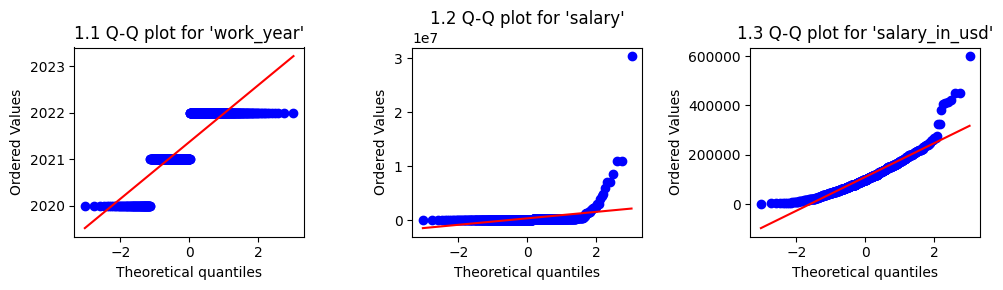

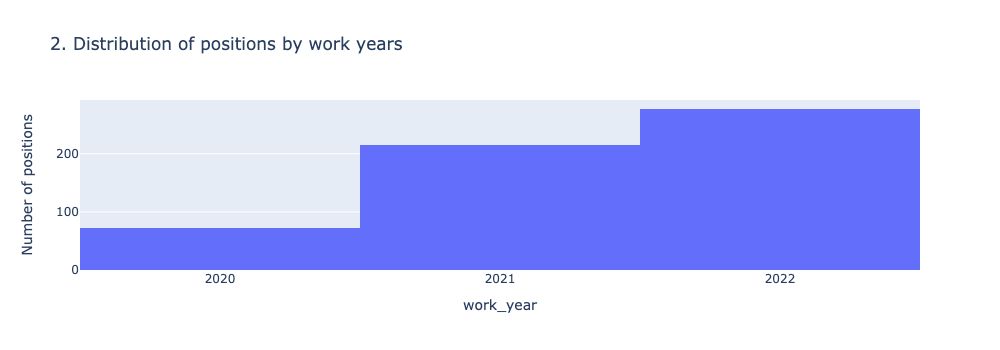

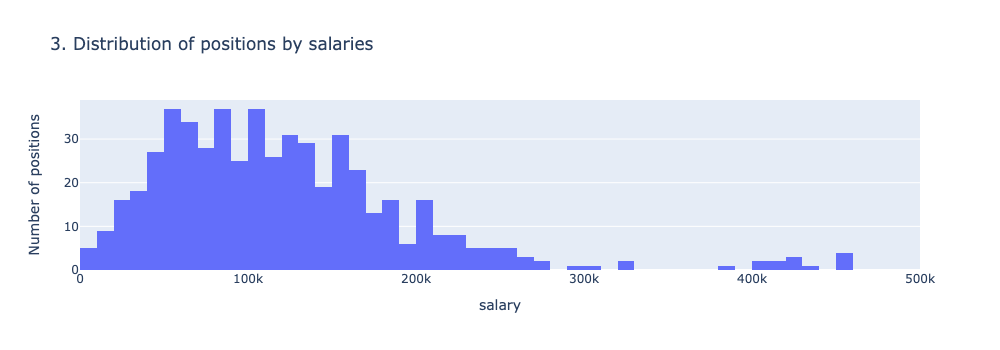

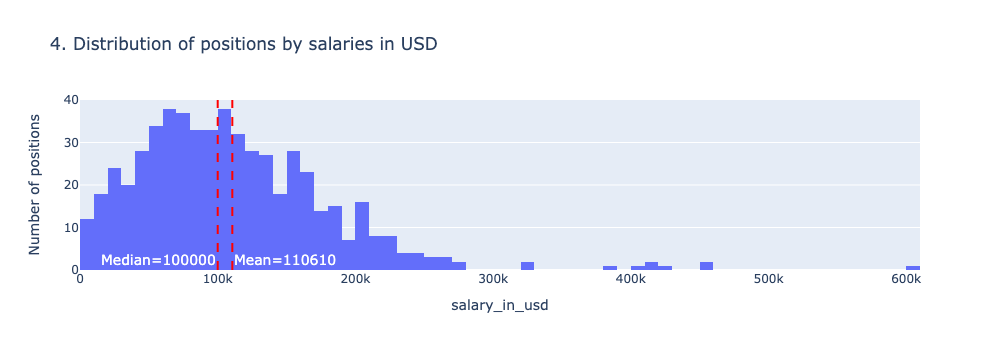

In [39]:
display('Visualizing numeric features:')

# Q-Q plots
plt.subplots(1, 3, figsize=(10, 3))

ax = plt.subplot(1, 3, 1)
stats.probplot(data['work_year'], plot=plt)
ax.set_title('1.1 Q-Q plot for \'work_year\'')

ax = plt.subplot(1, 3, 2)
stats.probplot(data['salary'], plot=plt)
ax.set_title('1.2 Q-Q plot for \'salary\'')

ax = plt.subplot(1, 3, 3)
stats.probplot(data['salary_in_usd'], plot=plt)
ax.set_title('1.3 Q-Q plot for \'salary_in_usd\'')

plt.tight_layout()
plt.show()

# Histograms
fig = px.histogram(
    data_frame=data,
    x='work_year',
    width=1000,
    height=350,
    title='2. Distribution of positions by work years'
).update_layout(
    yaxis_title='Number of positions',
    xaxis_tickvals=[*range(int(data['work_year'].min()), int(data['work_year'].max())+1)]
)
fig.show('png')

fig = px.histogram(
    data_frame=data,
    x='salary',
    width=1000,
    height=350,
    nbins=5000,
    title='3. Distribution of positions by salaries'
).update_layout(
    yaxis_title='Number of positions',
    xaxis_range=[0, 500000]
)
fig.show('png')

mean_salary_in_usd = data['salary_in_usd'].mean()
median_salary_in_usd = data['salary_in_usd'].median()
fig = px.histogram(
    data_frame=data,
    x='salary_in_usd',
    width=1000,
    height=350,
    nbins=100,
    title='4. Distribution of positions by salaries in USD'
).update_layout(
    yaxis_title='Number of positions'
)
fig.add_vline(
    mean_salary_in_usd, 
    line_color='red', 
    line_dash='dash', 
    annotation_text=f'Mean={round(mean_salary_in_usd)}', 
    annotation_position='bottom right',
    annotation_font=dict(size=14, color='white')
)
fig.add_vline(
    median_salary_in_usd, 
    line_color='red', 
    line_dash='dash', 
    annotation_text=f'Median={round(median_salary_in_usd)}', 
    annotation_position='bottom left',
    annotation_font=dict(size=14, color='white')
)
fig.show('png')

#### Conclusion on visualization of numeric features
None of the features has normal distribution.

Work year can be treated as a categorical feature, since there are just three values and each of the positions belongs to a single work year.

The salary in the local currency cannot be compared directly across the borders. This feature is not meaningful for further analysis.

Mean and median salary in USD are close to 100000 USD per year.

#### Visualization of the categorical features

'Visualizing categorical features:'

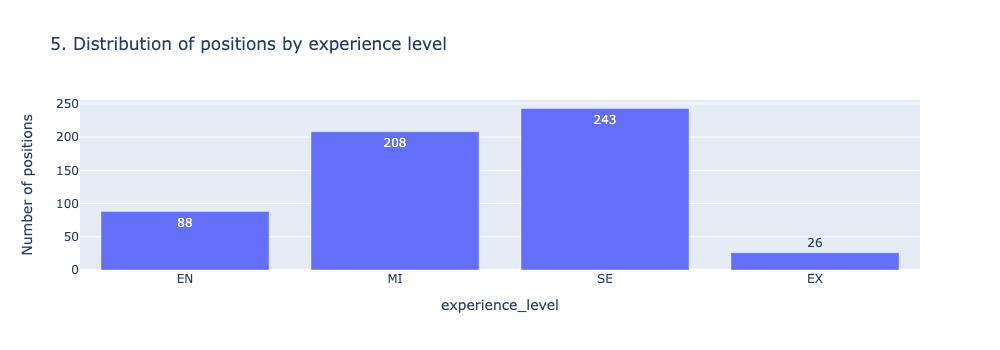

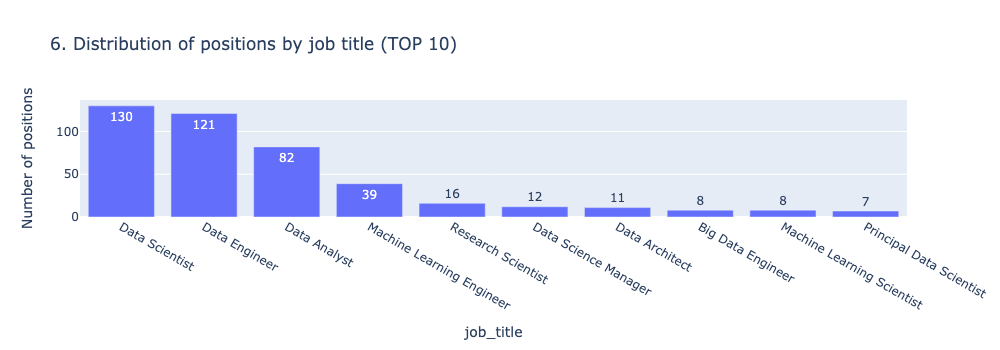

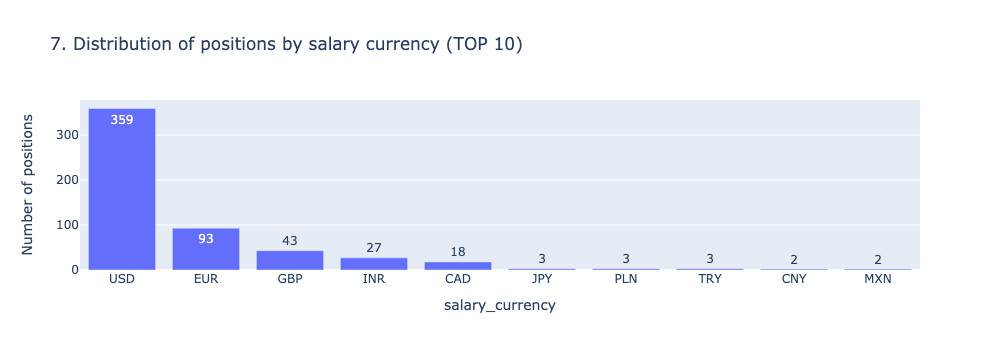

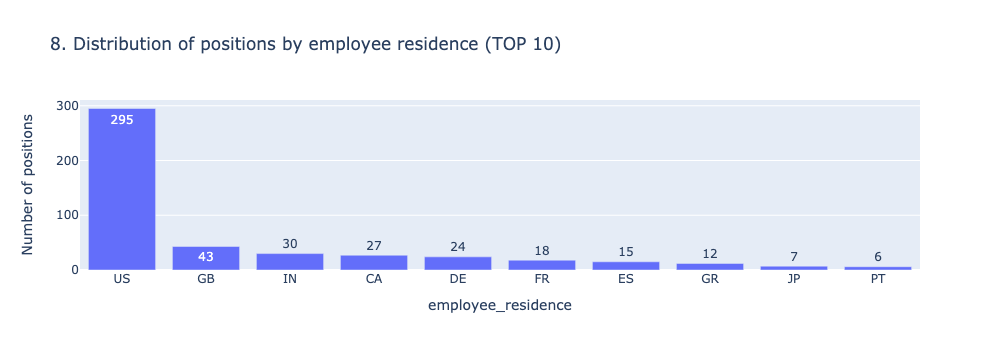

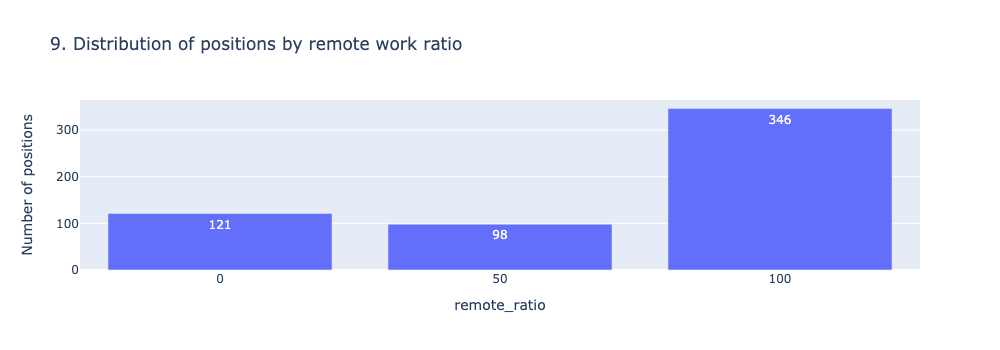

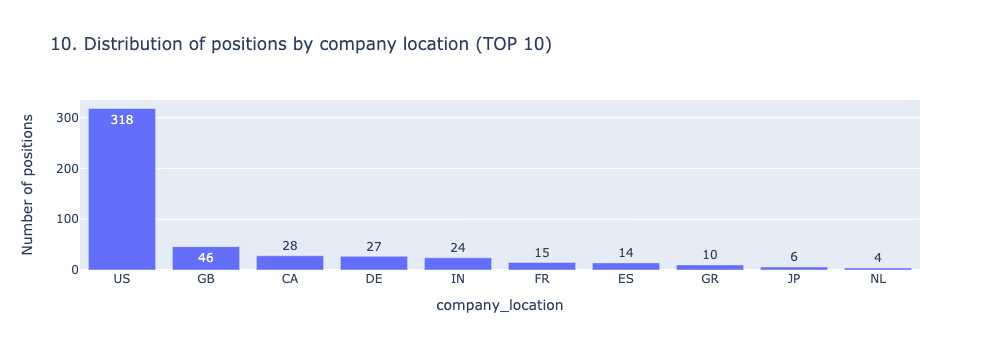

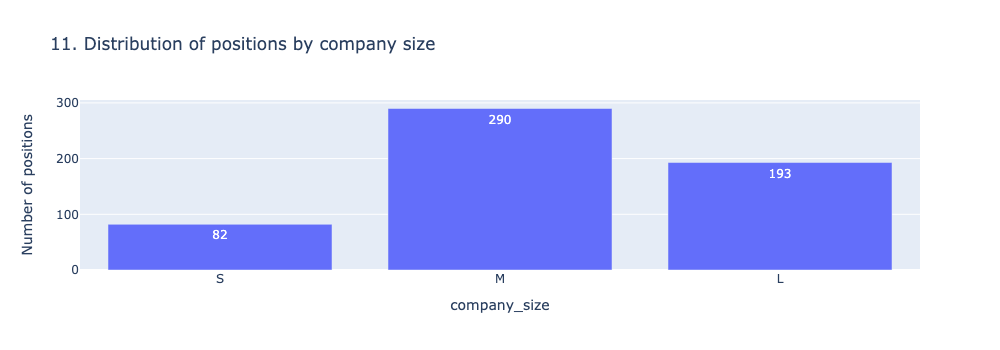

In [40]:
display('Visualizing categorical features:')

fig = px.bar(
    data['experience_level'].value_counts(),
    width=1000,
    height=350,
    title='5. Distribution of positions by experience level',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False,
    xaxis_categoryorder='array',
    xaxis_categoryarray=['EN', 'MI', 'SE', 'EX']
)
fig.show('png')

fig = px.bar(
    data_frame=data['job_title'].value_counts().head(10),
    width=1000,
    height=350,
    title='6. Distribution of positions by job title (TOP 10)',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False
)
fig.show('png')

fig = px.bar(
    data_frame=data['salary_currency'].value_counts().head(10),
    width=1000,
    height=350,
    title='7. Distribution of positions by salary currency (TOP 10)',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False
)
fig.show('png')

fig = px.bar(
    data_frame=data['employee_residence'].value_counts().head(10),
    width=1000,
    height=350,
    title='8. Distribution of positions by employee residence (TOP 10)',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False
)
fig.show('png')

fig = px.bar(
    data_frame=data['remote_ratio'].value_counts(),
    width=1000,
    height=350,
    title='9. Distribution of positions by remote work ratio',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False,
    xaxis_tickvals=[0, 50, 100]
)
fig.show('png')

fig = px.bar(
    data_frame=data['company_location'].value_counts().head(10),
    width=1000,
    height=350,
    title='10. Distribution of positions by company location (TOP 10)',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False
)
fig.show('png')

fig = px.bar(
    data_frame=data['company_size'].value_counts(),
    width=1000,
    height=350,
    title='11. Distribution of positions by company size',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False,
    xaxis_categoryorder='array',
    xaxis_categoryarray=['S', 'M', 'L']
)
fig.show('png')

#### Conclusion on visualization of the categorical features
Most of the jobs are in the middle and senior experience level (see figure 5).

"Data Scientist" and "Data Engineer" are the two most frequent job titles in the data set (see figure 6).

Most of the jobs are paid in USD or EUR (see figure 7).

Most of the companies and most of the employees are located in the following countries: USA, Great Britain, Canada, Germany and India (see figures 8 and 10).

More than 50 % of jobs assume remote work (see figure 9).

Middle size companies offer more jobs than small and large companies taken together (see figure 11).

#### Visualize relation between the salary in USD and other features
We consider the salary in USD for the analysis, since the salary in the local currency cannot be compared directly across the borders.

Only job titles "Data Scientist" and "Data Engineer" which are mentioned in the main study questions will be considered for the visualizations in this section.

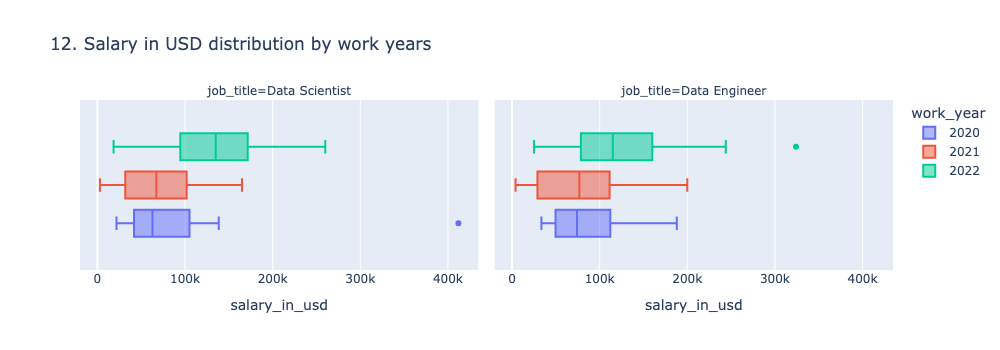

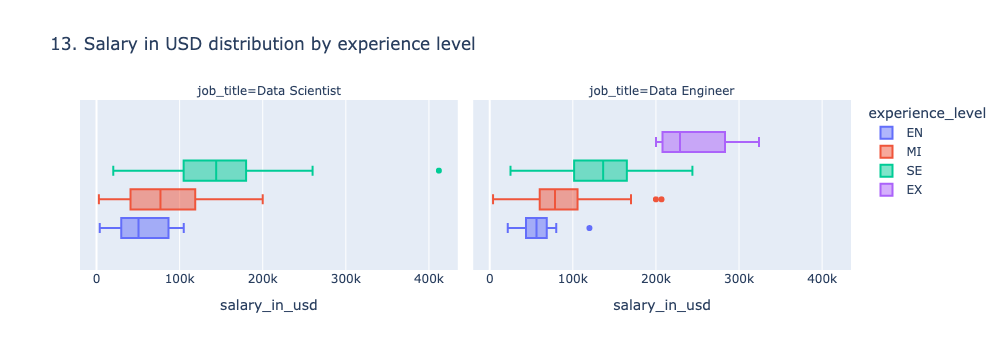

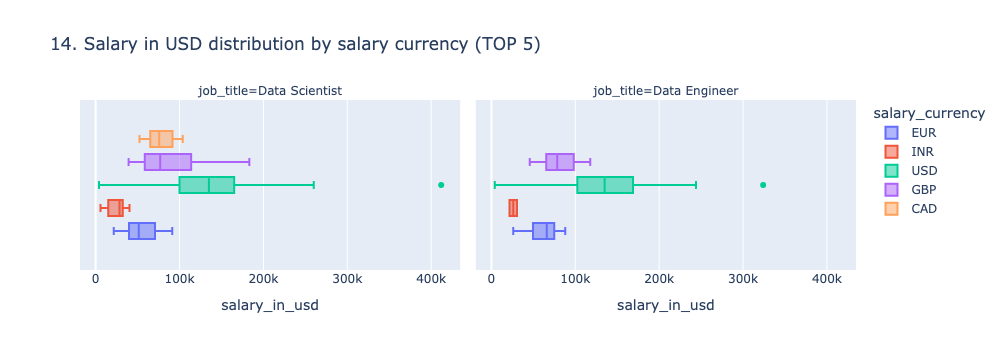

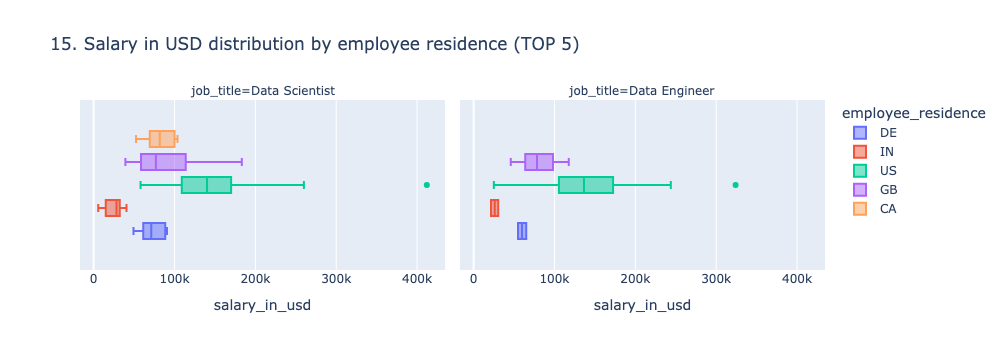

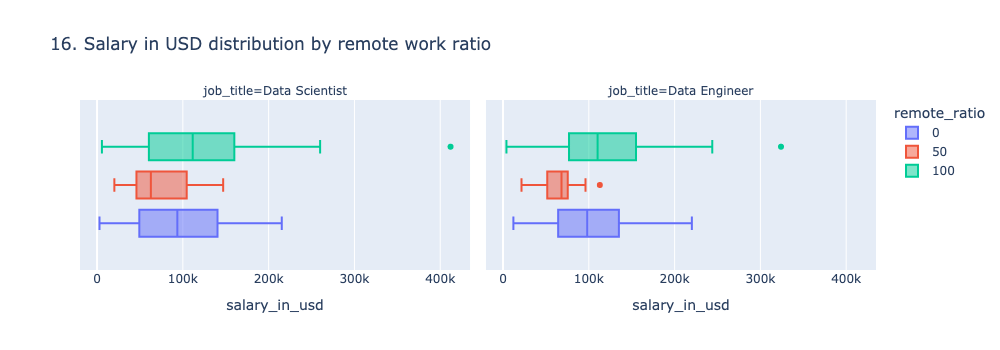

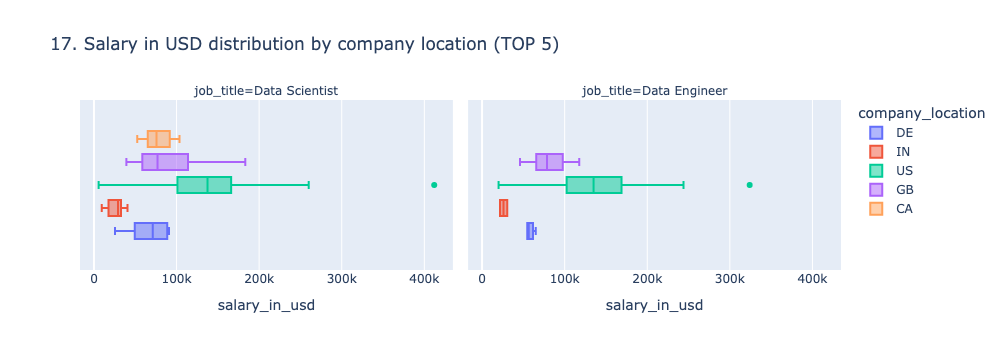

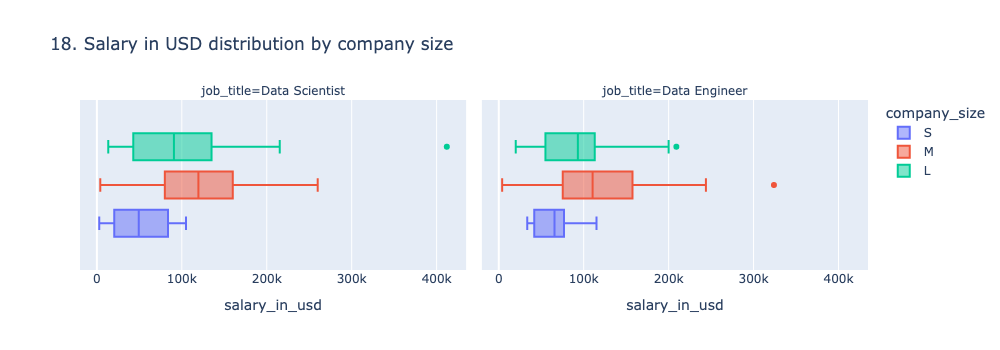

In [41]:
data_jobs_mask = (data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')
data_jobs_data = data[data_jobs_mask]

fig = px.box(
    data_frame=data_jobs_data,
    x='salary_in_usd',
    color='work_year',
    facet_col='job_title',
    width=1000,
    height=350,
    title='12. Salary in USD distribution by work years'
)
fig.show('png')

fig = px.box(
    data_frame=data_jobs_data,
    x='salary_in_usd',
    color='experience_level',
    facet_col='job_title',
    width=1000,
    height=350,
    title='13. Salary in USD distribution by experience level',
    category_orders={'experience_level': ['EN', 'MI', 'SE', 'EX']}
)
fig.show('png')

# Diagram is made for the TOP 5 salary currencies
salary_currencies = ['USD', 'EUR', 'GBP', 'INR', 'CAD']
fig = px.box(
    data_frame=data_jobs_data[data_jobs_data['salary_currency'].isin(salary_currencies)],
    x='salary_in_usd',
    color='salary_currency',
    facet_col='job_title',
    width=1000,
    height=350,
    title='14. Salary in USD distribution by salary currency (TOP 5)'
)
fig.show('png')

# Diagram is made for the TOP 5 employee residences
employee_residence = ['US', 'GB', 'IN', 'CA', 'DE']
fig = px.box(
    data_frame=data_jobs_data[data_jobs_data['employee_residence'].isin(employee_residence)],
    x='salary_in_usd',
    color='employee_residence',
    facet_col='job_title',
    width=1000,
    height=350,
    title='15. Salary in USD distribution by employee residence (TOP 5)'
)
fig.show('png')

fig = px.box(
    data_frame=data_jobs_data,
    x='salary_in_usd',
    color='remote_ratio',
    facet_col='job_title',
    width=1000,
    height=350,
    title='16. Salary in USD distribution by remote work ratio'
)
fig.show('png')

# Diagram is made for the TOP 5 company locations
company_location = ['US', 'GB', 'CA', 'DE', 'IN']
fig = px.box(
    data_frame=data_jobs_data[data_jobs_data['company_location'].isin(company_location)],
    x='salary_in_usd',
    color='company_location',
    facet_col='job_title',
    width=1000,
    height=350,
    title='17. Salary in USD distribution by company location (TOP 5)'
)
fig.show('png')

fig = px.box(
    data_frame=data_jobs_data,
    x='salary_in_usd',
    color='company_size',
    facet_col='job_title',
    width=1000,
    height=350,
    title='18. Salary in USD distribution by company size',
    category_orders={'company_size': ['S', 'M', 'L']}
)
fig.show('png')


#### Conclusion of visualizing relation between the salary in USD and other features
We'll colclude this part by answering the main questions of our study using the visualizations above.

1. Identify, which factors influence upon the salary of a "Data Scientist". 
    * **_Answer:_** These are: experience level, the currency in which the salary is getting paid, employee residence, remote work ratio, company location and company size (as an additional analysis I'll check if there is a dependency of the salary currency and the employee residence and company location).
2. Answer the key questions of the HR agency:
* Is there a yearly salary growth for the "Data Scientist" jobs? 
    * **_Answer:_** There was a slight decrease from the year 2020 to 2021 and an over 50 % increse from the year 2021 to 2022 (see figure 12). I can relate this booming increase with the attention to AI topics as part of the Data Science.
* What is the relation between the salaries of the "Data Scientist" and "Data Engineer" jobs in 2022? 
    * **_Answer:_** Based on the box plot we can see that the salaries of data engineers are slightly lower than the salaries of data scientists (see figure 12). This applies to all parameters like min and max values and all three quartiles (25 %, 50 % and 75 %).
* What is the relation between the "Data Scientist" salary and the company size? 
    * **_Answer:_** There is not linear grows of the salary along with the company growth. Middle size companies pay more than small companies, but large companies pay less than the middle size companies, but more than the small companies (see figure 18).
* Is there an interrelation between the company size and the presence of the "Data Scientist" or "Data Engineer" jobs in it? 
    * **_Answer:_** Based on the box plots we see that both data scientists and data engineers are present in all sizes of the companies (see figure 18). A more precise conclusion can be done via the statistical tests.

### Checking statistical hypothesis - Answering the main questions

#### Is there a yearly salary growth for the "Data Scientist" jobs? 
First of all we need to identify if the yearly values of the 'salary_in_usd' feature have a normal distribution. We'll use the Shapiro-Wilk test for that.

H0 = normal distribution

H1 = distribution is not normal

In [42]:
# Setting the significance level for the normality test and for the further statistical tests to 0.05.
alpha = 0.05

ds_data = data[data['job_title'] == 'Data Scientist']
ds_data_2020 = ds_data[ds_data['work_year'] == 2020]
ds_data_2021 = ds_data[ds_data['work_year'] == 2021]
ds_data_2022 = ds_data[ds_data['work_year'] == 2022]
display(f'Number of positions per year:')
display(f'2020 - {ds_data_2020.shape[0]}, 2021 - {ds_data_2021.shape[0]}, 2022 - {ds_data_2022.shape[0]}')

display_shapiro(ds_data_2020['salary_in_usd'], alpha)
display_shapiro(ds_data_2021['salary_in_usd'], alpha)
display_shapiro(ds_data_2022['salary_in_usd'], alpha)

'Number of positions per year:'

'2020 - 21, 2021 - 44, 2022 - 65'

p-value=0.000 is less than or equal to the defined statistical significance α=0.05. Data does not have normal distribution.
p-value=0.107 is greater than the defined statistical significance α=0.05. Data has normal distribution.
p-value=0.676 is greater than the defined statistical significance α=0.05. Data has normal distribution.


Shapiro-Wilk test has proven that the 'salary_in_usd' does not have a normal distribution in the year 2020, but it has normal distribution in the years 2021 and 2022. For more accurate results in the further analysis let's consider that the overall data for all three years does not have a normal distribution.

##### Picking an appropriate statistical test
To pick the correct statistical test we answer the following questions:
* What is the type of the 'salary_in_usd' feature?
    * **_Answer:_** Numeric.
* How many groups are being compared?
    * **_Answer:_** 3, for the years 2020, 2021 and 2022
* Are groups independent?
    * **_Answer:_** Yes, the groups are different in size.
* Does data have a normal distribution?
    * **_Answer:_** No, as proven by the Shapiro-Wilk test above.

The appropriate test is Kruskal-Wallis H-test. However this test is checking if the medians of the sample groups are equal. This does not answer the posed question. To be able to compare for the growth we'll check the salary values in pairs of years, i.e. 2020 vs 2021 and 2021 vs 2022. To pick the correct statistical test we answer the following questions:
* What is the type of the 'salary_in_usd' feature?
    * **_Answer:_** Numeric.
* How many groups are being compared?
    * **_Answer:_** 2, for the pairs of years 2020, 2021 and 2021, 2022
* Are groups independent?
    * **_Answer:_** Yes, the groups are different in size.
* Does data have a normal distribution?
    * **_Answer:_** No, as proven by the Shapiro-Wilk test above.

The appropriate test is Mann-Whitney U rank test.

µ1 - salaries in 2020 and µ2 - salaries in 2021, or respectively in 2021 and 2022

H0 = µ2 <= µ1 - null hypothesis

H1 = µ2 > µ1 - alternative hypothesis

In [43]:
_, p = stats.mannwhitneyu(ds_data_2021['salary_in_usd'], ds_data_2020['salary_in_usd'], alternative='greater')
display_pvalue_conclusion(p, alpha)
_, p = stats.mannwhitneyu(ds_data_2022['salary_in_usd'], ds_data_2021['salary_in_usd'], alternative='greater')
display_pvalue_conclusion(p, alpha)

p-value=0.705 is greater than the defined statistical significance α=0.05. The null hypothesis cannot be rejected.
p-value=0.000 is less than or equal to the defined statistical significance α=0.05. The null hypothesis can be rejected.


It has been statistically proven there is no ground to claim that there was a salary growth from 2020 to 2021, but there is salary growth from 2021 to 2022. This is matching the conclusion observed during the visual analysis (see figure 12).

#### What is the relation between the salaries of the "Data Scientist" and "Data Engineer" jobs in 2022? 

We have already checked above that the "Data Scientist" jobs 'salary_in_usd' has a normal distribution in year 2022. Let's check the same for the "Data Engineer" jobs in 2022 using the Shapiro-Wilk test.

In [44]:
de_data = data[data['job_title'] == 'Data Engineer']
de_data_2022 = de_data[de_data['work_year'] == 2022]
display_shapiro(de_data_2022['salary_in_usd'], alpha)

p-value=0.007 is less than or equal to the defined statistical significance α=0.05. Data does not have normal distribution.


"Data Engineer" salary data does not have a normal distribution. We'll consider that in the selection of the statistical test.

##### Picking an appropriate statistical test
To pick the correct statistical test we answer the following questions:
* What is the type of the 'salary_in_usd' feature?
    * **_Answer:_** Numeric.
* How many groups are being compared?
    * **_Answer:_** 2, data scientists and data engineers.
* Are groups independent?
    * **_Answer:_** Yes.
* Does data have a normal distribution?
    * **_Answer:_** No, as proven by the Shapiro-Wilk test above.

The appropriate test is Mann-Whitney U rank test.

µ1 - salaries of data scientists in 2022 and µ2 - salaries of data engineers in 2022

We have seen in the visual analysis that the data scientists salaries are higher than those of data engineers (see figure 12). Let's use this relation in the hypothesis:

H0 = µ1 <= µ2 - null hypothesis

H1 = µ1 > µ2 - alternative hypothesis

In [45]:
_, p = stats.mannwhitneyu(ds_data_2022['salary_in_usd'], de_data_2022['salary_in_usd'], alternative='greater')
display_pvalue_conclusion(p, alpha)

p-value=0.160 is greater than the defined statistical significance α=0.05. The null hypothesis cannot be rejected.


Based on the statistical test we cannot claim that data scientists salaries were higher than salaries of data engineers in the year 2022. This does not match the conclusion observed during the visual analysis (see figure 12).

#### What is the relation between the "Data Scientist" salary and the company size?
We need to check if the "Data Scientist" jobs 'salary_in_usd' has a normal distribution for each size of the companies present in the study. We do this using the Shapiro-Wilk test.

In [46]:
ds_data_s = ds_data[ds_data['company_size'] == 'S']
ds_data_m = ds_data[ds_data['company_size'] == 'M']
ds_data_l = ds_data[ds_data['company_size'] == 'L']

display_shapiro(ds_data_s['salary_in_usd'], alpha)
display_shapiro(ds_data_m['salary_in_usd'], alpha)
display_shapiro(ds_data_l['salary_in_usd'], alpha)

p-value=0.189 is greater than the defined statistical significance α=0.05. Data has normal distribution.
p-value=0.897 is greater than the defined statistical significance α=0.05. Data has normal distribution.
p-value=0.000 is less than or equal to the defined statistical significance α=0.05. Data does not have normal distribution.


"Data Scientist" salaries data in the small and medium companies has a normal distribution, but in the large companies it does not. We'll consider the data as not normally distributed for all company sizes to get more accurate results.

##### Picking an appropriate statistical test
To pick the correct statistical test we answer the following questions:
* What is the type of the 'salary_in_usd' feature?
    * **_Answer:_** Numeric.
* How many groups are being compared?
    * **_Answer:_** 3, small, medium and large companies.
* Are groups independent?
    * **_Answer:_** Yes.
* Does data have a normal distribution?
    * **_Answer:_** No, as proven by the Shapiro-Wilk test above.

The appropriate test is the Kruskal-Wallis H-test. The null hypothesis is that the population median of all of the groups are equal.

H0 = M1 == M2 == M3

H1 = M1 <> M2 <> M3

In [47]:
_, p = stats.kruskal(ds_data_s['salary_in_usd'], ds_data_m['salary_in_usd'], ds_data_l['salary_in_usd'])
display_pvalue_conclusion(p, alpha)

p-value=0.000 is less than or equal to the defined statistical significance α=0.05. The null hypothesis can be rejected.


Statistical test proves that the medians of the salararies of data scientists in companies of different sizes are different. This confirms the observation which was made in the visual analysis (see figure 18). A more detailed analysis can be done to compare the salries pairwise between the companies of different sizes.

#### Is there an interrelation between the company size and the presence of the "Data Scientist" or "Data Engineer" jobs in it?

We need to analyze the feature 'company_size' for the "Data Scientist" and "Data Engineer" job titles. The features 'job_title' and 'company_size' are categorical ones. They are not binary, thus the Chi-square test of independence of variables in a contingency table is an appropriate test for this case.

The null hypothesis is in this case that there is no interrelation between the company size and the presence of the "Data Scientist" or "Data Engineer" jobs in it.

H0: there is no interrelation

H1: there is interrelation

In [48]:
crosstab_company_size = pd.crosstab(data_jobs_data['job_title'], data_jobs_data['company_size'])
display(crosstab_company_size)
res = stats.chi2_contingency(crosstab_company_size)
display_pvalue_conclusion(res.pvalue, alpha)

company_size,L,M,S
job_title,,,
Data Engineer,34,81,6
Data Scientist,43,66,21


p-value=0.005 is less than or equal to the defined statistical significance α=0.05. The null hypothesis can be rejected.


The test has proven that there is a statistical interrelation between the company size and the presence of the "Data Scientist" and "Data Engineer" jobs in it. This ammends the conclusions which have been received during the visual analysis (see figure 18).

### Addintional analysis

We'll perform analysis and answer the following questions for the given dataset.

1. Is the mean "Data Scientist" 'salary_in_usd' greater than 100000 in 2022?
2. Is there an interrelation between the company size and the company location? The analysis will consider the top 5 countries by number of positions.
3. Is 'salary_in_usd' higher in case of fully remote work and on-side and hybrid models?

#### Visual data analysis

##### Is the mean "Data Scientist" 'salary_in_usd' greater than 100000 in 2022?
We'll build a Q-Q plot and a histogram to visually present this data.

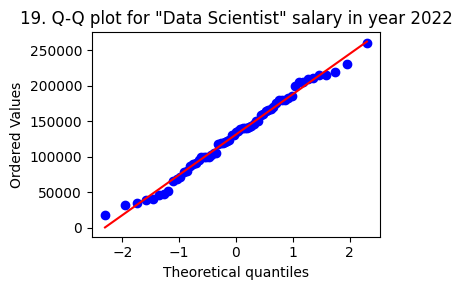

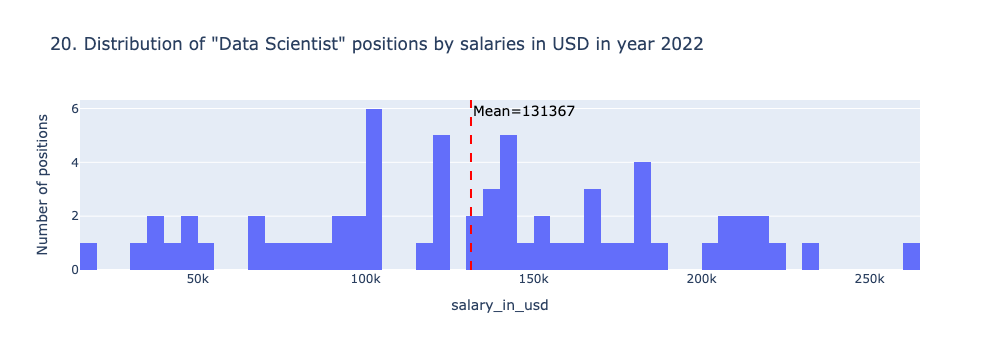

In [49]:
# Q-Q plot
plt.subplots(1, 1, figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
stats.probplot(ds_data_2022['salary_in_usd'], plot=plt)
ax.set_title('19. Q-Q plot for "Data Scientist" salary in year 2022')
plt.tight_layout()
plt.show()

# Histogram
mean_ds_salary_in_usd_2022 = ds_data_2022['salary_in_usd'].mean()
fig = px.histogram(
    data_frame=ds_data_2022,
    x='salary_in_usd',
    width=1000,
    height=350,
    nbins=100,
    title='20. Distribution of "Data Scientist" positions by salaries in USD in year 2022'
).update_layout(
    yaxis_title='Number of positions'
)
fig.add_vline(
    mean_ds_salary_in_usd_2022, 
    line_color='red', 
    line_dash='dash', 
    annotation_text=f'Mean={round(mean_ds_salary_in_usd_2022)}', 
    annotation_position='top right',
    annotation_font=dict(size=14, color='black')
)
fig.show('png')

The Q-Q plot (see figure 19) shows that the 'salary_in_usd' of data scientists has a normal distribution in the year 2022. This has also been proven by the Shapiro-Wilk test above.

The histogram (see figure 20) does not allow to make an assumption if the distribution is normal, but we see that the calculated mean value is 131367 USD. Preliminarily based on the visual presentation we can conclude that the mean salary of data scientists in the year 2022 is higher than 100000 USD.

##### 2. Is there an interrelation between the company size and the company location? The analysis will consider the top 5 countries by number of positions.
We'll build a bar chart to present the company size and company location data.

company_size,L,M,S
company_location,,,
CA,11,14,3
DE,11,9,7
GB,11,30,5
IN,13,7,4
US,102,186,30


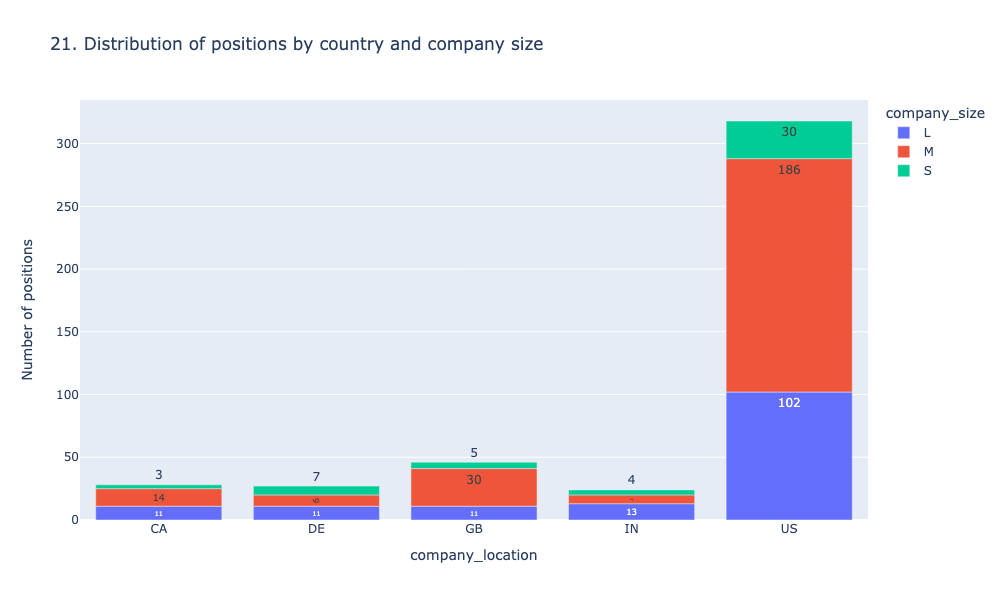

In [50]:
top_5_countries = ['US', 'GB', 'CA', 'DE', 'IN']
mask_top_5_countries = data['company_location'].isin(top_5_countries)
data_top_5_countries = data[mask_top_5_countries]

crosstab_company_size_loc = pd.crosstab(data_top_5_countries['company_location'], data_top_5_countries['company_size'])
display(crosstab_company_size_loc)
fig = px.bar(
    data_frame=crosstab_company_size_loc,
    width=1000,
    height=600,
    title='21. Distribution of positions by country and company size',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions'
)
fig.show('png')

It is hard to give the answer based on the visual representation (see figure 21). More precise results will be recieved using the statistical analisis.

##### 3. Is 'salary_in_usd' higher in case of fully remote work and on-side and hybrid models?
We will convert the 'remote_ratio' feature to a one hot feature 'is_remote' using the following mapping:
* 100: 1
* 0 or 50: 0
Then we'll build the Q-Q plots and the histograms of the 'salary_in_usd' for both values of 'is_remote'.

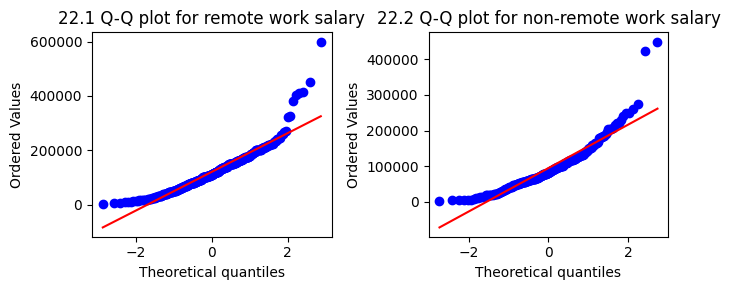

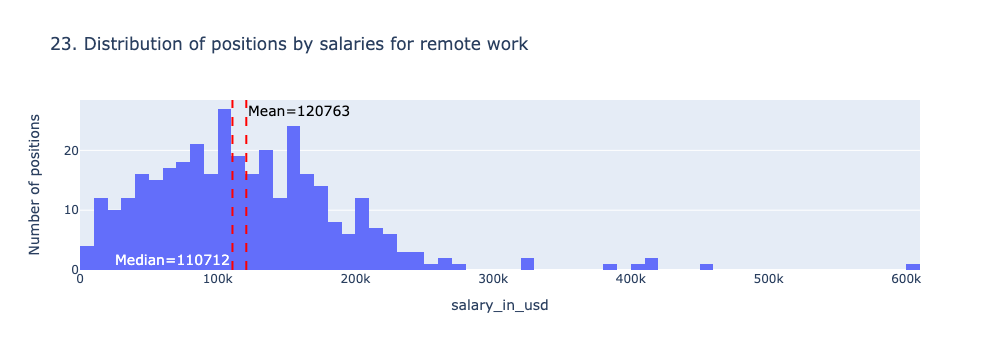

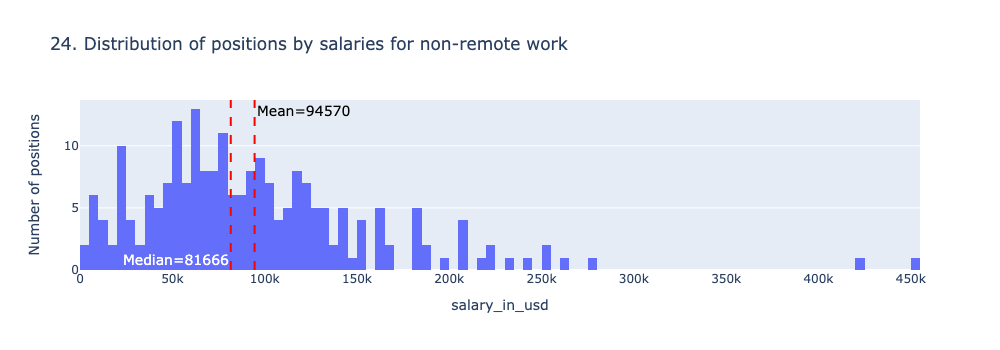

In [51]:
data['is_remote'] = data['remote_ratio'].apply(lambda x: 1 if x == 100 else 0)

mask_remote = data['is_remote'] == 1
mask_non_remote = data['is_remote'] == 0
data_remote = data[mask_remote]
data_non_remote = data[mask_non_remote]

# Q-Q plots
plt.subplots(1, 2, figsize=(7, 3))

ax = plt.subplot(1, 2, 1)
stats.probplot(data_remote['salary_in_usd'], plot=plt)
ax.set_title('22.1 Q-Q plot for remote work salary')

ax = plt.subplot(1, 2, 2)
stats.probplot(data_non_remote['salary_in_usd'], plot=plt)
ax.set_title('22.2 Q-Q plot for non-remote work salary')

plt.tight_layout()
plt.show()

# Histograms
mean_remote_salary_in_usd = data_remote['salary_in_usd'].mean()
median_remote_salary_in_usd = data_remote['salary_in_usd'].median()
fig = px.histogram(
    data_frame=data_remote,
    x='salary_in_usd',
    width=1000,
    height=350,
    nbins=100,
    title='23. Distribution of positions by salaries for remote work'
).update_layout(
    yaxis_title='Number of positions'
)
fig.add_vline(
    mean_remote_salary_in_usd, 
    line_color='red', 
    line_dash='dash', 
    annotation_text=f'Mean={round(mean_remote_salary_in_usd)}', 
    annotation_position='top right',
    annotation_font=dict(size=14, color='black')
)
fig.add_vline(
    median_remote_salary_in_usd, 
    line_color='red', 
    line_dash='dash', 
    annotation_text=f'Median={round(median_remote_salary_in_usd)}', 
    annotation_position='bottom left',
    annotation_font=dict(size=14, color='white')
)
fig.show('png')

mean_non_remote_salary_in_usd = data_non_remote['salary_in_usd'].mean()
median_non_remote_salary_in_usd = data_non_remote['salary_in_usd'].median()
fig = px.histogram(
    data_frame=data_non_remote,
    x='salary_in_usd',
    width=1000,
    height=350,
    nbins=100,
    title='24. Distribution of positions by salaries for non-remote work'
).update_layout(
    yaxis_title='Number of positions'
)
fig.add_vline(
    mean_non_remote_salary_in_usd, 
    line_color='red', 
    line_dash='dash', 
    annotation_text=f'Mean={round(mean_non_remote_salary_in_usd)}', 
    annotation_position='top right',
    annotation_font=dict(size=14, color='black')
)
fig.add_vline(
    median_non_remote_salary_in_usd, 
    line_color='red', 
    line_dash='dash', 
    annotation_text=f'Median={round(median_non_remote_salary_in_usd)}', 
    annotation_position='bottom left',
    annotation_font=dict(size=14, color='white')
)
fig.show('png')

The Q-Q plots (see figures 22.1 and 22.2) show that the 'salary_in_usd' feature distribution is not normal for both remote work grouop and non-remote work group.

The histograms (see fibures 23 and 24) preliminarily convey that the 'salary_in_usd' is higher for the remote work than for the non-remote work. This is also confirmed by the mean and median values. Medians are lower than the mean values due to the outliers visible on the right sides of the charts.

#### Checking statistical hypothesis - Answering the additional questions

##### 1. Is the mean "Data Scientist" 'salary_in_usd' greater than 100000 in 2022?
The "Data Scientist" salaries in 2022 have been checked using the Shapiro-Wilk test and the distribution is normal.

To pick the correct statistical test we answer the following questions:
* What is the type of the 'salary_in_usd' feature?
    * **_Answer:_** Numeric.
* How many groups are being compared?
    * **_Answer:_** 1, data scientist salaries within one year.
* Does data have a normal distribution?
    * **_Answer:_** Yes, as proven by the Shapiro-Wilk test above.

The appropriate test is T-test for the mean of one group.

µ - salaries of data scientists in 2022

H0 = µ <= 100000 - null hypothesis

H1 = µ > 100000 - alternative hypothesis

In [52]:
_, p = stats.ttest_1samp(ds_data_2022['salary_in_usd'], popmean=100000, alternative='greater')
display_pvalue_conclusion(p, alpha)

p-value=0.000 is less than or equal to the defined statistical significance α=0.05. The null hypothesis can be rejected.


It has been statistically proven that the null hypothesis can be rejected and thus the mean salary of data scientists in the year 2022 is higher than 100000 USD.

##### 2. Is there an interrelation between the company size and the company location? The analysis will consider the top 5 countries by number of positions.
We need to analyze the features 'company_size' and 'company_location'. Both features are categorical ones. They are not binary, thus the Chi-square test of independence of variables in a contingency table is an appropriate statistical test for this case.

The null hypothesis is in this case that there is no interrelation between the company size and the company location.

H0: there is no interrelation

H1: there is interrelation

In [53]:
res = stats.chi2_contingency(crosstab_company_size_loc)
display_pvalue_conclusion(res.pvalue, alpha)

p-value=0.015 is less than or equal to the defined statistical significance α=0.05. The null hypothesis can be rejected.


The statistical test has proven that there is an interrelation between the comapny size and company location.

##### 3. Is 'salary_in_usd' higher in case of fully remote work and on-side and hybrid models?
First of all we need to perform the Shapiro-Wilk normality test to confirm the visual analysis (see figures 22.1 and 22.2) that the distribution of the 'salary_in_usd' feature for both groups is not normal.

In [54]:
display_shapiro(data_remote['salary_in_usd'], alpha)
display_shapiro(data_non_remote['salary_in_usd'], alpha)

p-value=0.000 is less than or equal to the defined statistical significance α=0.05. Data does not have normal distribution.
p-value=0.000 is less than or equal to the defined statistical significance α=0.05. Data does not have normal distribution.


Shapiro-Wilk test has proven that the data in both groups does not have a normal distribution.

To pick the correct statistical test we answer the following questions:
* What is the type of the 'salary_in_usd' feature?
    * **_Answer:_** Numeric.
* How many groups are being compared?
    * **_Answer:_** 2, remote work and non-remote work.
* Are groups independent?
    * **_Answer:_** Yes.
* Does data have a normal distribution?
    * **_Answer:_** No, as proven by the Shapiro-Wilk test above.

The appropriate test is Mann-Whitney U rank test.

µ1 - salaries for remote work and µ2 - salaries for non-remote work

We have seen in the visual analysis that the salaries for remote work are higher than those for non-remote work (see figures 23 and 24). Let's use this relation in the hypothesis:

H0 = µ1 <= µ2 - null hypothesis

H1 = µ1 > µ2 - alternative hypothesis

In [55]:
_, p = stats.mannwhitneyu(data_remote['salary_in_usd'], data_non_remote['salary_in_usd'], alternative='greater')
display_pvalue_conclusion(p, alpha)

p-value=0.000 is less than or equal to the defined statistical significance α=0.05. The null hypothesis can be rejected.


The statistical test has proven that the null hypothesis can be rejected, thus the salaries for remote work are higher than those for non-remote work.

## Conclusions
### Answers to required questions
* Is there a yearly salary growth for the "Data Scientist" jobs?
    * **_Answer:_** It has been statistically proven there is no ground to claim that there was a salary growth for "Data Scientist" jobs from 2020 to 2021, but there is salary growth from 2021 to 2022. This is matching the conclusion observed during the visual analysis (see figure 12).
* What is the relation between the salaries of the "Data Scientist" and "Data Engineer" jobs in 2022?
    * **_Answer:_** Based on the statistical test we cannot claim that data scientists salaries were higher than salaries of data engineers in the year 2022. This does not match the conclusion observed during the visual analysis (see figure 12).
* What is the relation between the "Data Scientist" salary and the company size?
    * **_Answer:_**  Statistical test proves that the medians of the salararies of data scientists in companies of different sizes are different. This confirms the observation which was made in the visual analysis (see figure 18). A more detailed analysis can be done to compare the salries pairwise between the companies of different sizes.
* Is there an interrelation between the company size and the presence of the "Data Scientist" or "Data Engineer" jobs in it?
    * **_Answer:_** The test has proven that there is a statistical interrelation between the company size and the presence of the "Data Scientist" and "Data Engineer" jobs in it. This ammends the conclusions which have been received during the visual analysis (see figure 18).
### Answers to additional questions
1. Is the mean "Data Scientist" 'salary_in_usd' greater than 100000 in 2022?
    * **_Answer:_** It has been statistically proven that the the mean salary of data scientists in the year 2022 is higher than 100000 USD.
2. Is there an interrelation between the company size and the company location? The analysis will consider the top 5 countries by number of positions.
    * **_Answer:_** The statistical test has proven that there is an interrelation between the comapny size and company location.
3. Is 'salary_in_usd' higher in case of fully remote work and on-side and hybrid models?
    * **_Answer:_** The statistical test has proven that the salaries for remote work are higher than those for non-remote work.

TODOs:
- update the tasks readme.md file
- update the main readme.md file
- Update my profile, add scipy